### **Waste Garbage Classification Using  Pre-train VGG - 16**


*  **Using Transfer Learning**
*   **Using Fine Tuning** 



In [2]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import os
import cv2
import sklearn 
import tensorflow as tf
from tensorflow import keras
from PIL import Image as im
from glob import glob
from sklearn.model_selection import train_test_split
import keras
#from tf.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from PIL import Image as im
import cv2

In [3]:
# Set seeds to make the experiment more reproducible.
import random
def seed_everything(seed = 0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
seed = 0
seed_everything(seed)

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [4]:
BATCH_SIZE = 64
img_height = 244
img_width = 244

# **Load Datasets**

In [5]:
import os
data_path = '/content/drive/MyDrive/Garbage_Data'
os.listdir(data_path)

['train', 'test']

In [6]:
input_path = data_path
train_data_dir = input_path + '/' + 'train'
test_data_dir = input_path + '/' + 'test'

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    validation_split = 0.2,
    subset = 'training',
    label_mode = 'categorical',
    image_size = (img_height, img_width),
    batch_size = BATCH_SIZE,
    seed = 123)

Found 2187 files belonging to 7 classes.
Using 1750 files for training.


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    validation_split = 0.2,
    subset = 'validation',
    label_mode = 'categorical',
    image_size = (img_height, img_width),
    batch_size = BATCH_SIZE,
    seed = 123)

Found 2187 files belonging to 7 classes.
Using 437 files for validation.


In [9]:
class_names = train_ds.class_names
print(class_names)

['cardboard', 'compost', 'glass', 'metal', 'paper', 'plastic', 'trash']


# **DataSets Visualizations**

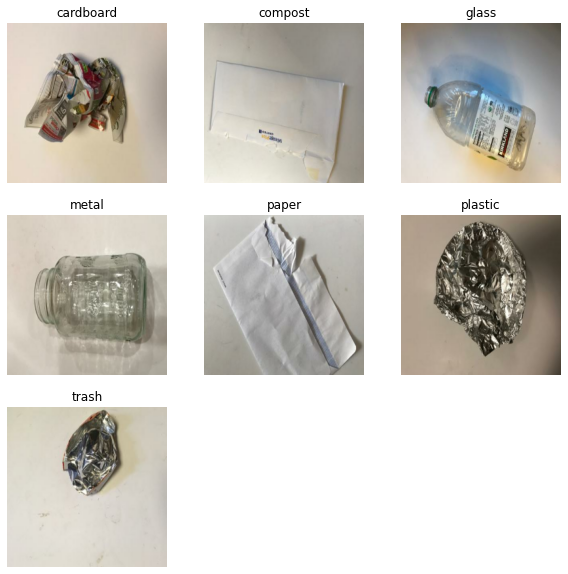

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(len(class_names)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[i])
    plt.axis("off")

In [11]:
data_augmentation = keras.Sequential([
    #layers.CenterCrop(125, 125),
    layers.RandomFlip('horizontal', input_shape = (img_height, img_width, 3)),
    layers.RandomRotation(0.2, fill_mode = 'nearest'),
    layers.RandomZoom(0.1),
])

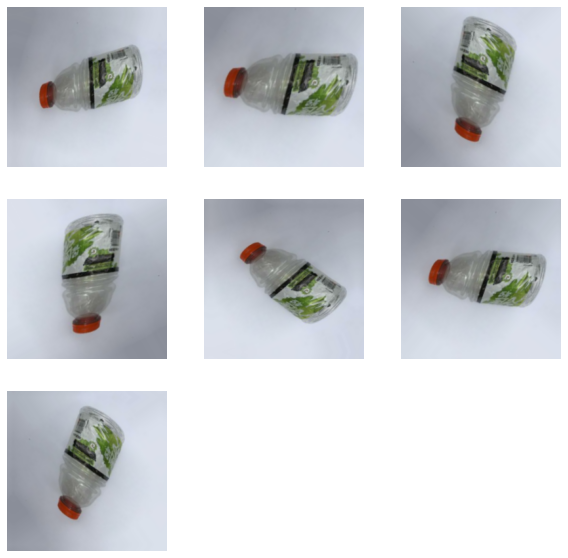

In [12]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(len(class_names)):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

# **Model Architecture** 

*   **Tranfer Learning**







In [72]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = (img_height, img_width, 3)
base_model = tf.keras.applications.VGG16(input_shape = IMG_SHAPE,
                                         include_top = False,
                                         weights = 'imagenet')
base_model.trainable = False
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 244, 244, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 244, 244, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 244, 244, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 122, 122, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 122, 122, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 122, 122, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 61, 61, 128)       0     

In [15]:
n_classes = len(class_names)

model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation = 'relu'),
    layers.Dropout(0.4),
    layers.Dense(n_classes, activation = 'softmax')
])

In [16]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 244, 244, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 244, 244, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                      

In [18]:
# Model Chackpoint
tl_checkpoint_1 = ModelCheckpoint(filepath = 'vgg16_best_weights.hdf5', save_best_only = True, verbose = 0)

# EarlyStopping
early_stop = EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True, mode = 'min')

#ReduceLROnPlateau to stabilize the training process of the model
rop_callback = ReduceLROnPlateau(monitor = 'val_loss', patience = 3, verbose = 1, factor = 0.5, min_lr = 0.000001)

In [19]:
%%time
history = model.fit(train_ds,
                    epochs = 20,
                    validation_data = val_ds,
                    callbacks = [tl_checkpoint_1, early_stop, rop_callback])

Epoch 1/20
28/28 [==============================] - 293s 3s/step - loss: 1.7325 - accuracy: 0.3091 - val_loss: 1.4344 - val_accuracy: 0.4668 - lr: 0.0010
Epoch 2/20
28/28 [==============================] - 14s 493ms/step - loss: 1.3981 - accuracy: 0.4640 - val_loss: 1.2510 - val_accuracy: 0.5515 - lr: 0.0010
Epoch 3/20
28/28 [==============================] - 14s 509ms/step - loss: 1.2533 - accuracy: 0.5349 - val_loss: 1.1445 - val_accuracy: 0.6270 - lr: 0.0010
Epoch 4/20
28/28 [==============================] - 14s 502ms/step - loss: 1.1422 - accuracy: 0.5686 - val_loss: 1.0803 - val_accuracy: 0.6156 - lr: 0.0010
Epoch 5/20
28/28 [==============================] - 14s 494ms/step - loss: 1.0847 - accuracy: 0.5846 - val_loss: 1.0083 - val_accuracy: 0.6522 - lr: 0.0010
Epoch 6/20
28/28 [==============================] - 14s 507ms/step - loss: 1.0306 - accuracy: 0.6194 - val_loss: 0.9824 - val_accuracy: 0.6430 - lr: 0.0010
Epoch 7/20
28/28 [==============================] - 14s 503ms/step

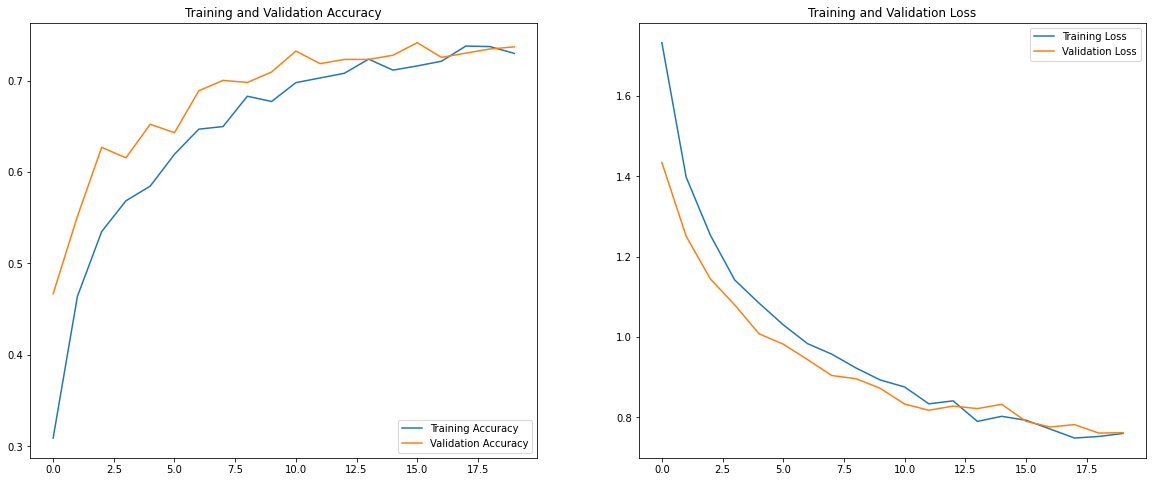

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize = (20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

In [58]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_data_dir,
    label_mode = 'categorical',
    image_size = (img_height, img_width),
    batch_size = 1,
    seed = 123)

test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

Found 564 files belonging to 7 classes.


In [59]:
# Generate predictions
model.load_weights('/content/drive/MyDrive/Garbage_Data/vgg16_best_weights.hdf5') # initialize the best trained weights
preds = model.predict(test_ds)
pred_classes = np.argmax(preds, axis = 1)

In [60]:
model.evaluate(test_ds, verbose = 1)

564/564 [==============================] - 7s 12ms/step - loss: 0.8269 - accuracy: 0.7216


[0.8269237875938416, 0.7216312289237976]

# **Fine Tuning**

In [78]:
def fine_tune(num_layer):
  for layer in base_model.layers[:-num_layer]:
    layer.trainable = False

  fine_model = base_model.output
  fine_model = Flatten(name="flatten")(fine_model)
  fine_model = Dense(4096, activation='relu')(fine_model)
  fine_model = Dense(1072, activation='relu')(fine_model)
  fine_model = Dropout(0.2)(fine_model)
  output_layer = Dense(n_classes, activation='softmax')(fine_model)
  model = Model(inputs=base_model.input, outputs=output_layer)

  return model


In [94]:
new_model = fine_tune(2)
new_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 244, 244, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 244, 244, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 244, 244, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 122, 122, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 122, 122, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 122, 122, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 61, 61, 128)       0   

In [95]:
model_2 = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    new_model,
    
])

In [96]:
model_2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 244, 244, 3)       0         
                                                                 
 rescaling_4 (Rescaling)     (None, 244, 244, 3)       0         
                                                                 
 model_1 (Functional)        (None, 7)                 121878727 
                                                                 
Total params: 121,878,727
Trainable params: 107,164,039
Non-trainable params: 14,714,688
_________________________________________________________________


In [97]:
model_2.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [98]:
# Model Chackpoint
tl_checkpoint_1 = ModelCheckpoint(filepath = 'vgg16_best_weights_fine_tuning.hdf5', save_best_only = True, verbose = 0)

# EarlyStopping
early_stop = EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True, mode = 'min')

#ReduceLROnPlateau to stabilize the training process of the model
rop_callback = ReduceLROnPlateau(monitor = 'val_loss', patience = 3, verbose = 1, factor = 0.5, min_lr = 0.000001)

In [100]:
%%time
history = model_2.fit(train_ds,
                    epochs = 20,
                    validation_data = val_ds,
                    callbacks = [tl_checkpoint_1, early_stop, rop_callback])

Epoch 1/20
28/28 [==============================] - 21s 756ms/step - loss: 1.5251 - accuracy: 0.4206 - val_loss: 1.0890 - val_accuracy: 0.5973 - lr: 0.0010
Epoch 2/20
28/28 [==============================] - 20s 738ms/step - loss: 1.0224 - accuracy: 0.6171 - val_loss: 0.9121 - val_accuracy: 0.6682 - lr: 0.0010
Epoch 3/20
28/28 [==============================] - 15s 527ms/step - loss: 0.8866 - accuracy: 0.6771 - val_loss: 0.9281 - val_accuracy: 0.6636 - lr: 0.0010
Epoch 4/20
28/28 [==============================] - 20s 735ms/step - loss: 0.7855 - accuracy: 0.6989 - val_loss: 0.7743 - val_accuracy: 0.7162 - lr: 0.0010
Epoch 5/20
28/28 [==============================] - 14s 512ms/step - loss: 0.7281 - accuracy: 0.7326 - val_loss: 0.7971 - val_accuracy: 0.7208 - lr: 0.0010
Epoch 6/20
28/28 [==============================] - 21s 747ms/step - loss: 0.6555 - accuracy: 0.7651 - val_loss: 0.7658 - val_accuracy: 0.7368 - lr: 0.0010
Epoch 7/20
28/28 [==============================] - 20s 750ms/st

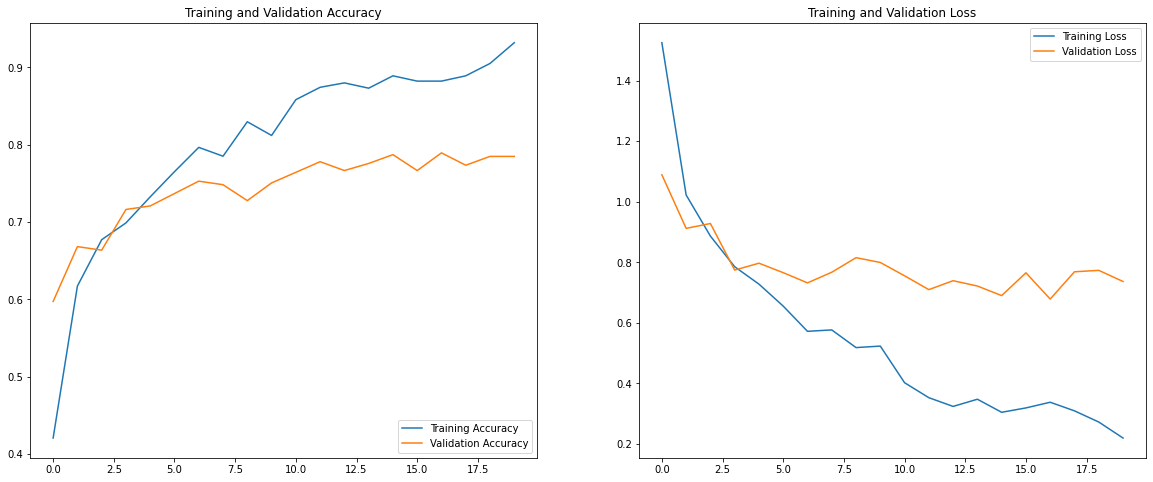

In [105]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize = (20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

In [106]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_data_dir,
    label_mode = 'categorical',
    image_size = (img_height, img_width),
    batch_size = 1,
    seed = 123)

test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

Found 564 files belonging to 7 classes.


In [107]:
# Generate predictions
model.load_weights('/content/vgg16_best_weights_fine_tuning.hdf5') # initialize the best trained weights
preds = model.predict(test_ds)
pred_classes = np.argmax(preds, axis = 1)

In [108]:
model_2.evaluate(test_ds, verbose = 1)

564/564 [==============================] - 8s 14ms/step - loss: 0.9016 - accuracy: 0.7553


[0.9016304612159729, 0.7553191781044006]

# **Concludes**

**Accuracy On Transfer Learning : 72.1%** </br>
**Accuracy On Fine Tuning : 75.5%**</br>
